<a href="https://colab.research.google.com/github/styxx216/EYES_TEST/blob/main/Eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kmeans-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2
import albumentations
from albumentations import pytorch as AT
import random
import pandas as pd
from kmeans_pytorch import kmeans
import sklearn
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
BATH_SIZE = 8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/Без названия/train'
#PATH_TO_TRAIN_DATA='https://drive.google.com/uc?id=' + url.split('/')[-2]
url = 'https://drive.google.com/file/d/1ocYoFBuzQwVQu_XBes0x6IWkOlY7i9ww/view?usp=sharing'
PATH_TO_LABELS = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [ ]:
class dataset(Dataset):
    def __init__(self, path,transform=None):
        self.path = path
        self.transform = transform
    def __len__(self):
        res = len(os.listdir(self.path))
        return res
    def __getitem__(self,idx):
        path = self.path+'//'+os.listdir(self.path)[idx]
        image = cv2.imread(path,0)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        image = torch.tensor(image).float().to(device)
        image = image.reshape([1,24,24])
        return image, path

In [ ]:
class labeled_dataset(Dataset):
    def __init__(self, path,path_to_labels,transform=None):
        self.path = path
        self.transform = transform
        self.df = pd.read_csv(path_to_labels)
        self.df = self.df[self.df.marks.notnull()]
    def __len__(self):
        res = len(self.df)
        return res
    def __getitem__(self,idx):
        t = self.df.iloc[idx]
        path = self.path+'//'+t['pathes']
        image = cv2.imread(path,0)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        image = torch.tensor(image).float().to(device)/225
        image = torch.unsqueeze(image, 0)
        label = t.marks
        return image, label

In [ ]:
data_transformation = albumentations.Compose([
    albumentations.RandomBrightnessContrast(p=0.5),
    albumentations.HorizontalFlip()
    ])

In [ ]:
img_set = labeled_dataset(PATH_TO_TRAIN_DATA,PATH_TO_LABELS, transform = data_transformation)

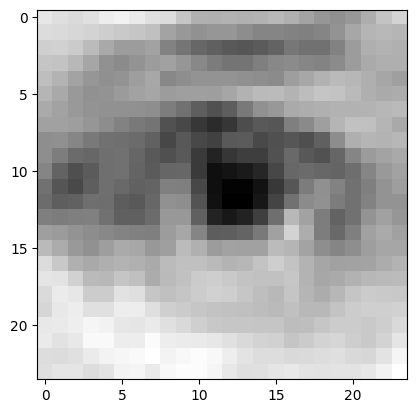

In [ ]:
plt.imshow(img_set[8][0].cpu()[0], cmap = 'gray')

In [ ]:
train_set, test_set = sklearn.model_selection.train_test_split(img_set,test_size=0.1)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, 
                                        batch_size=BATH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, 
                                        batch_size=1, shuffle=True)

In [ ]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1,8,cernal_size=3,padding=1)#[24,24,1]->[24,24,8]
        self.bn_1 = torch.nn.BatchNorm2d(8)
        self.conv_2 = torch.nn.Conv2d(8,16,cernal_size=3,padding=1)#[24,24,8]->[24,24,16]
        self.bn_2 = torch.nn.BatchNorm2d(16)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv_3 = torch.nn.Conv2d(16,32,cernal_size=3,padding=1)#[12,12,16]->[12,12,32]
        self.bn_3 = torch.nn.BatchNorm2d(32)
        self.conv_4 = torch.nn.Conv2d(32,64,cernal_size=3,padding=1)#[12,12,32]->[12,12,64]
        self.bn_4 = torch.nn.BatchNorm2d(64)
        self.conv_5 = torch.nn.Conv2d(64,128,cernal_size=3,padding=1)#[6,6,64]->[6,6,128]
        self.bn_5 = torch.nn.BatchNorm2d(128)
        self.conv_6 = torch.nn.Conv2d(128,256,cernal_size=3,padding=1)#[6,6,128]->[6,6,256]
        self.bn_6 = torch.nn.BatchNorm2d(256)
        #[3,3,256]
        self.fc_1 = torch.nn.Linear(3*3*256, 1024)
        self.fc_2 = torch.nn.Linear(1024, 1)
    def forvard(self,x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = F.relu(x)
        x = self.conv_6(x)
        x = self.bn_6(x)
        x = F.relu(x)
        x = self.pool(x)


        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = self.fc_2(x)

        return x




In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1,4,kernel_size=5,padding=2)#[24,24,1]->[24,24,4]
        self.bn_1 = torch.nn.BatchNorm2d(4)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv_2 = torch.nn.Conv2d(4,8,kernel_size=3,padding=1)#[12,12,4]->[12,12,8]
        self.bn_2 = torch.nn.BatchNorm2d(8)
        self.conv_3 = torch.nn.Conv2d(8,16,kernel_size=3,padding=1)#[6,6,8]->[6,6,16]
        self.bn_3 = torch.nn.BatchNorm2d(16)
    def forward(self,x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.pool(x)
        return x
class TestModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()

        self.fc_1 = torch.nn.Linear(3*3*16, 254)
        self.fc_2 = torch.nn.Linear(254, 1)
    def forward(self,x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = torch.sigmoid(x)
        return x
        

Разметка для 5% изображений

Основная идея - сначала обучить декодер (расстояние между представителями одного класса должно уменьшаться, между представителями разных классов - увеличиваться)

In [ ]:
model = TestModel()
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
n_epoch = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

In [ ]:
def test_model(model,testloader):
  total = 0
  correct = 0
  with torch.no_grad():
      model.eval()
      for data, labels in testloader:
        labels=labels.to(device)
        data = data.to(device)
        outputs = model(data)
        outputs = outputs.cpu().numpy()
        outputs = np.round(outputs)
        predicted = outputs
        total += len(labels)
        print(predicted[:,0])
        print(labels.cpu().reshape(-1).numpy())
        print(list(np.equal(predicted,labels.cpu().reshape(-1).numpy())))
        correct += list(np.equal(predicted,labels.cpu().reshape(-1).numpy())).count(True)
                  
  accuracy = correct / total
  return accuracy

In [ ]:
model.train()
train_loss = []
train_losses = []
train_acc = []
test_acc = []
for epoch in range(n_epoch):
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))
torch.save(model.state_dict(),'/content/drive/MyDrive/test_model.pth')

 Номер эпохи: 1, Трейн лосс: 0.7024545268261735, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 2, Трейн лосс: 0.696518104218874, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 3, Трейн лосс: 0.6884019813842878, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 4, Трейн лосс: 0.6784352683640263, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 5, Трейн лосс: 0.6680802317369849, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 6, Трейн лосс: 0.6585137431522882, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 7, Трейн лосс: 0.6500839254506952, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 8, Трейн лосс: 0.6429439227735353, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 9, Трейн лосс: 0.6367608710744007, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 10, Трейн лосс: 0.6313337754106814, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 11, Трейн лосс: 0.626541671921869, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 12, Трейн лосс: 0.6222584033006603, Текущий лернинг рейт: 5e-05 
 Номер эпохи: 13, Трейн лосс: 0.6183573522066348, Текущий лерни

In [ ]:
model.encoder.requires_grad_(False)

Encoder(
  (conv_1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)